In [1]:
# Install necessary packages
# !pip install xgboost
# !pip install optuna

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import gc
import time
import warnings
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, brier_score_loss, confusion_matrix, classification_report
)
from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

import shap
import optuna

# Global Configuration
base_dir = Path().resolve()
results_dir = base_dir.parent / "results"
results_dir.mkdir(exist_ok=True)

TUNE_MODE = True        # Enable Optuna tuning
N_TRIALS = 3 #The one we use will be 20, we can do 10 if too slow
SEED = 42
fl_n = 200

print(f"TUNE_MODE: {'ON' if TUNE_MODE else 'OFF'} | Optuna Trials: {N_TRIALS}")

2025-10-16 19:28:34.443403: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 19:28:34.515922: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 19:28:36.674742: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TUNE_MODE: ON | Optuna Trials: 3


In [ ]:
# Step 1: Import the preprocessed data
df_flux = pd.read_csv("dataset/fluxomics.csv", index_col=0)
df_gene = pd.read_csv("dataset/transcriptomic_hvg.csv", index_col=0)
meta_data = pd.read_csv("dataset/metadata.csv", index_col=0)

In [ ]:
#  Step 2: Prepare data for ML models
# Remove exchange reaction
rxns = [c for c in df_flux.columns if c != "response" and not c.startswith("EX_")]
flux = df_flux[rxns]

# Select top variable fluxes
fl_top = flux.var().sort_values(ascending=False).index[:fl_n]

# Select top HVG genes
tr_n = 250
hvg_genes = pd.read_csv("dataset/hvg_genes.csv",header=None).squeeze().tolist()
tr_top = [g for g in hvg_genes if g in df_gene.columns][:tr_n]

X_gene= df_gene[tr_top]
X_flux = flux[fl_top]

# Intergrate data
X = pd.merge(X_gene, X_flux, left_index=True, right_index=True)
y = meta_data.loc[X.index,:]['response']


#  Encode target variable
y = y.map({"Responder": 1, "Non-responder": 0}).astype(np.int8)
print(X.shape)

(51324, 450)


In [8]:
X.head()

,ENSG00000244734,ENSG00000163736,ENSG00000143546,ENSG00000211653,ENSG00000211945,ENSG00000239951,ENSG00000163220,ENSG00000275896,ENSG00000188536,ENSG00000244437,...,r0407,ASNS1,LYStm,r0450,r0525,AASAD3m,SACCD3m,VALTAim,VALt5m,AcetoacetylACPsynthesis
AAACCTGAGACTGTAA-1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000302,0.000114,0.000099,0.000099,0.000099,0.000099,0.000099,0.0,0.0,0.000136
AAACCTGAGCAGCGTA-1,0.0,0.0,5.401019,0.0,0.0,0.0,4.001265,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000143
AAACCTGAGCCAACAG-1,0.0,0.0,1.658036,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000285,0.000000,0.000132,0.000132,0.000132,0.000132,0.000132,0.0,0.0,0.000132
AAACCTGAGCGTGAAC-1,0.0,0.0,1.119160,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000291,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000134
AAACCTGAGCTACCTA-1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000290,0.000000,0.000116,0.000116,0.000116,0.000116,0.000116,0.0,0.0,0.000133


In [9]:
# 2.3 Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=SEED)
# 2.4 Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [10]:
# Step 3: Train and evaluate ML models

#  3.1 define evaluation function for each model
def evaluate_model(model, X_test, y_test, model_name):
    """Compute all metrics including Brier and MCC."""
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > 0.5).astype(int)
    else:
        y_prob = model.predict(X_test)
        y_pred = (y_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    mcc = matthews_corrcoef(y_test, y_pred)
    brier = brier_score_loss(y_test, y_prob)

    print(f"✅ {model_name}: acc={acc:.3f}, f1={f1:.3f}, auc={auc:.3f}, mcc={mcc:.3f}, brier={brier:.3f}")
    return acc, prec, rec, f1, auc, mcc, brier

# 3.2 Optuna Objective Functions with class balance
def class_balance(y):
    neg, pos = (y == 0).sum(), (y == 1).sum()
    return neg / pos if pos > 0 else 1.0

# Logistic Regression
def tune_logreg(trial, X_train, X_val, y_train, y_val):
    C = trial.suggest_float("C", 1e-3, 100, log=True)
    w = class_balance(y_train)
    model = LogisticRegression(solver="lbfgs", max_iter=1000, C=C, class_weight={0: 1, 1: w})
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# Random Forest
def tune_rf(trial, X_train, X_val, y_train, y_val):
    w = class_balance(y_train)
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800, step=200),
        "max_depth": trial.suggest_int("max_depth", 6, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": {0: 1, 1: w}
    }
    model = RandomForestClassifier(random_state=SEED, n_jobs=-1, **params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# XGBoost
def tune_xgb(trial, X_train, X_val, y_train, y_val):
    w = class_balance(y_train)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": w,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=200)
    }
    model = xgb.XGBClassifier(**params, n_jobs=-1, random_state=SEED, verbosity=0)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

# ANN
def tune_ann(trial, X_train, X_val, y_train, y_val):
    w = class_balance(y_train)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.2, 0.6)
    n1 = trial.suggest_int("n1", 32, 128, step=32)
    n2 = trial.suggest_int("n2", 16, 64, step=16)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(n1, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(n2, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy", metrics=["accuracy"])

    early = EarlyStopping(patience=5, restore_best_weights=True)
    sample_weights = np.where(y_train == 1, w, 1)
    model.fit(X_train, y_train, sample_weight=sample_weights,
              validation_data=(X_val, y_val),
              epochs=30, batch_size=32, verbose=0, callbacks=[early])
    preds = model.predict(X_val)
    return roc_auc_score(y_val, preds)

In [11]:
#  3.3 Run hyperparameter tuning and evaluation for LR

w = class_balance(y_train)   # Compute class ratio
print(f"Class balance ratio: neg/pos = {w:.2f}")

name = "Logistic Regression"
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: tune_logreg(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"✅ {name} best AUC={study.best_value:.3f} | params={study.best_params}")


#  Update model
model_lr = LogisticRegression(
                    **study.best_params, solver="lbfgs", max_iter=1000, class_weight={0: 1, 1: w}
                )

# Refit model
model_lr.fit(X_train, y_train)


[I 2025-10-16 19:32:04,002] A new study created in memory with name: no-name-109c92e8-07a2-438b-9b6e-7cb46f2e7cc4


Class balance ratio: neg/pos = 1.97


Best trial: 0. Best value: 0.866013:  33%|███▎      | 1/3 [00:09<00:18,  9.22s/it]

[I 2025-10-16 19:32:13,219] Trial 0 finished with value: 0.8660126474007113 and parameters: {'C': 0.44479301358405826}. Best is trial 0 with value: 0.8660126474007113.


Best trial: 0. Best value: 0.866013:  67%|██████▋   | 2/3 [00:11<00:05,  5.19s/it]

[I 2025-10-16 19:32:15,597] Trial 1 finished with value: 0.8657399733515241 and parameters: {'C': 0.0025306595660432585}. Best is trial 0 with value: 0.8660126474007113.


Best trial: 2. Best value: 0.866205: 100%|██████████| 3/3 [00:14<00:00,  4.73s/it]


[I 2025-10-16 19:32:18,173] Trial 2 finished with value: 0.8662050333530966 and parameters: {'C': 0.00500281729672899}. Best is trial 2 with value: 0.8662050333530966.
✅ Logistic Regression best AUC=0.866 | params={'C': 0.00500281729672899}


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.00500281729672899
,fit_intercept,True
,intercept_scaling,1
,class_weight,"{0: 1, 1: np.float64(1.9706972958306954)}"
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'



[Responder Class Metrics]
Accuracy     : 77.73
Precision    : 62.73
Recall       : 83.36
F1 Score     : 71.59
ROC AUC Score: 86.55

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.90      0.75      0.82      6810
    Responder       0.63      0.83      0.72      3455

     accuracy                           0.78     10265
    macro avg       0.76      0.79      0.77     10265
 weighted avg       0.81      0.78      0.78     10265



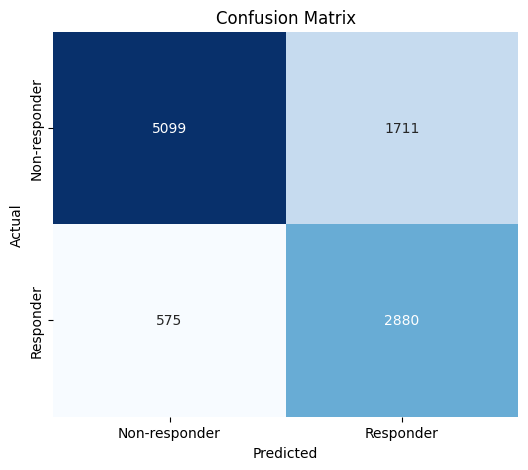

In [12]:
#  Evaluate model

# Predictions
y_prob = model_lr.predict_proba(X_test)[:, 1]
y_pred = model_lr.predict(X_test)   # default 0.5 threshold

# Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-responder", "Responder"]))

#  Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 19:32:21,239] A new study created in memory with name: no-name-e883ba38-a6a5-424a-9774-a1383ab3d0b0
Best trial: 0. Best value: 0.828072:  33%|███▎      | 1/3 [00:04<00:08,  4.50s/it]

[I 2025-10-16 19:32:25,733] Trial 0 finished with value: 0.8280717734412024 and parameters: {'n_estimators': 600, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.8280717734412024.


Best trial: 1. Best value: 0.828153:  67%|██████▋   | 2/3 [00:08<00:04,  4.38s/it]

[I 2025-10-16 19:32:30,033] Trial 1 finished with value: 0.8281531904856015 and parameters: {'n_estimators': 600, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.8281531904856015.


Best trial: 2. Best value: 0.832858: 100%|██████████| 3/3 [00:10<00:00,  3.54s/it]


[I 2025-10-16 19:32:31,863] Trial 2 finished with value: 0.8328584448467926 and parameters: {'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.8328584448467926.
✅ RF best AUC=0.833 | params={'n_estimators': 200, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}

[Responder Class Metrics]
Accuracy     : 77.73
Precision    : 62.73
Recall       : 83.36
F1 Score     : 71.59
ROC AUC Score: 86.55

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.90      0.75      0.82      6810
    Responder       0.63      0.83      0.72      3455

     accuracy                           0.78     10265
    macro avg       0.76      0.79      0.77     10265
 weighted avg       0.81      0.78      0.78     10265



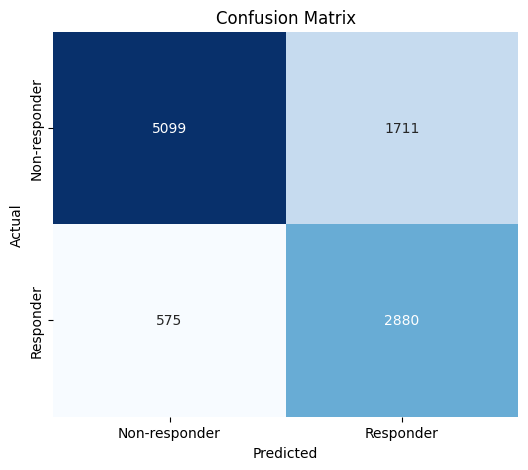

In [13]:
#  3.4 Run hyperparameter tuning and evaluation for RF

name = "RF"
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(lambda trial: tune_rf(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"✅ {name} best AUC={study_rf.best_value:.3f} | params={study_rf.best_params}")


#  Update model
model_rf = RandomForestClassifier(**study_rf.best_params, random_state=SEED, n_jobs=-1, class_weight={0: 1, 1: w})

# Refit model
model_rf.fit(X_train, y_train)

#  Evaluate model
# Predictions
y_prob_rf = model_lr.predict_proba(X_test)[:, 1]
y_pred_rf = model_lr.predict(X_test)   # default 0.5 threshold

# Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_rf)
roc = roc_auc_score(y_test, y_prob_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Non-responder", "Responder"]))

#  Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 19:32:33,773] A new study created in memory with name: no-name-57806b67-4c92-461f-aa40-1ae08317cfc2
Best trial: 0. Best value: 0.902203:  33%|███▎      | 1/3 [00:18<00:36, 18.19s/it]

[I 2025-10-16 19:32:51,965] Trial 0 finished with value: 0.9022025900448605 and parameters: {'learning_rate': 0.26183449788864277, 'max_depth': 5, 'subsample': 0.896671924689499, 'colsample_bytree': 0.9180606132800238, 'n_estimators': 400}. Best is trial 0 with value: 0.9022025900448605.


Best trial: 0. Best value: 0.902203:  67%|██████▋   | 2/3 [00:43<00:22, 22.14s/it]

[I 2025-10-16 19:33:16,866] Trial 1 finished with value: 0.9007480406782399 and parameters: {'learning_rate': 0.18457377832424593, 'max_depth': 5, 'subsample': 0.7670036746754353, 'colsample_bytree': 0.6971966138180565, 'n_estimators': 600}. Best is trial 0 with value: 0.9022025900448605.


Best trial: 2. Best value: 0.9095: 100%|██████████| 3/3 [01:06<00:00, 22.33s/it]  


[I 2025-10-16 19:33:40,764] Trial 2 finished with value: 0.9095004393598414 and parameters: {'learning_rate': 0.0672766668313079, 'max_depth': 6, 'subsample': 0.9864663662777537, 'colsample_bytree': 0.9725271254208578, 'n_estimators': 400}. Best is trial 2 with value: 0.9095004393598414.
✅ GB best AUC=0.910 | params={'learning_rate': 0.0672766668313079, 'max_depth': 6, 'subsample': 0.9864663662777537, 'colsample_bytree': 0.9725271254208578, 'n_estimators': 400}

[Responder Class Metrics]
Accuracy     : 82.70
Precision    : 70.04
Recall       : 84.92
F1 Score     : 76.77
ROC AUC Score: 91.16

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.91      0.82      0.86      6810
    Responder       0.70      0.85      0.77      3455

     accuracy                           0.83     10265
    macro avg       0.81      0.83      0.81     10265
 weighted avg       0.84      0.83      0.83     10265



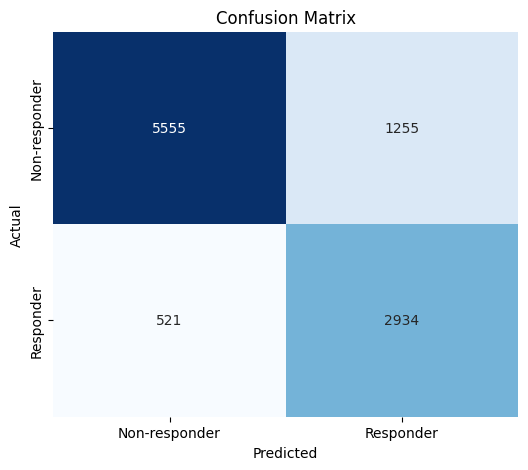

In [14]:
#  3.5 Run hyperparameter tuning and evaluation for XGB
name = "GB"
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(lambda trial: tune_xgb(trial, X_train, X_val, y_train, y_val), n_trials=N_TRIALS, show_progress_bar=True)
print(f"✅ {name} best AUC={study_gb.best_value:.3f} | params={study_gb.best_params}")


#  Update model
model_gb = xgb.XGBClassifier(**study_gb.best_params, n_jobs=-1, random_state=SEED, verbosity=0, scale_pos_weight=w)

# Refit model
model_gb.fit(X_train, y_train)

#  Evaluate model
# Predictions
y_prob_gb = model_gb.predict_proba(X_test)[:, 1]
y_pred_gb = model_gb.predict(X_test)   # default 0.5 threshold

# Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_gb)
roc = roc_auc_score(y_test, y_prob_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=["Non-responder", "Responder"]))

#  Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[I 2025-10-16 19:33:59,157] A new study created in memory with name: no-name-f1dccd18-e907-472d-974e-05633fb1c9b6
  0%|          | 0/3 [00:00<?, ?it/s]2025-10-16 19:33:59.171788: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


Best trial: 0. Best value: 0.886579:  33%|███▎      | 1/3 [00:24<00:48, 24.26s/it]

[I 2025-10-16 19:34:23,423] Trial 0 finished with value: 0.8865787854011402 and parameters: {'lr': 0.0029957960865283125, 'dropout': 0.2477441512260269, 'n1': 128, 'n2': 64}. Best is trial 0 with value: 0.8865787854011402.
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


Best trial: 1. Best value: 0.888135:  67%|██████▋   | 2/3 [01:18<00:41, 41.75s/it]

[I 2025-10-16 19:35:17,410] Trial 1 finished with value: 0.88813510607326 and parameters: {'lr': 0.00017991894239790382, 'dropout': 0.572981195626888, 'n1': 64, 'n2': 64}. Best is trial 1 with value: 0.88813510607326.
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


Best trial: 1. Best value: 0.888135: 100%|██████████| 3/3 [01:43<00:00, 34.55s/it]

[I 2025-10-16 19:35:42,821] Trial 2 finished with value: 0.8859248259029986 and parameters: {'lr': 0.0007766546682617041, 'dropout': 0.21482289499827464, 'n1': 128, 'n2': 16}. Best is trial 1 with value: 0.88813510607326.
✅ ANN best AUC=0.888 | params={'lr': 0.00017991894239790382, 'dropout': 0.572981195626888, 'n1': 64, 'n2': 64}


321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step

[Responder Class Metrics]
Accuracy     : 81.03
Precision    : 69.23
Recall       : 78.55
F1 Score     : 73.60
ROC AUC Score: 88.75

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.88      0.82      0.85      6810
    Responder       0.69      0.79      0.74      3455

     accuracy                           0.81     10265
    macro avg       0.79      0.80      0.79     10265
 weighted avg       0.82      0.81      0.81     10265



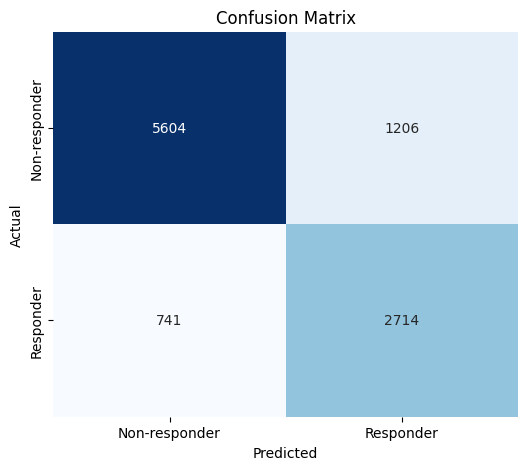

In [15]:
#  3.6 Run hyperparameter tuning and evaluation for ANN 
name = 'ANN'
study_ann = optuna.create_study(direction="maximize") 
study_ann.optimize(lambda trial: tune_ann(trial, X_train, X_val, y_train, y_val),
                   n_trials=N_TRIALS, show_progress_bar=True)

print(f"✅ {name} best AUC={study_ann.best_value:.3f} | params={study_ann.best_params}")


# --- Retrain Final ANN Model with Best Params ---
best_params = study_ann.best_params
w = class_balance(y_train)

ann = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(best_params["n1"], activation="relu"),
    layers.Dropout(best_params["dropout"]),
    layers.Dense(best_params["n2"], activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

ann.compile(
    optimizer=optimizers.Adam(learning_rate=best_params["lr"]),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
sample_weights = np.where(y_train == 1, w, 1)

ann.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30, batch_size=32, verbose=0,
    sample_weight=sample_weights,
    callbacks=[early_stop]
)

# --- Evaluate Final Model ---
y_prob_ann = ann.predict(X_test)
y_pred_ann = (y_prob_ann > 0.5).astype(int)

# Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_ann)
roc = roc_auc_score(y_test, y_prob_ann)
precision = precision_score(y_test, y_pred_ann)
recall = recall_score(y_test, y_pred_ann)
f1 = f1_score(y_test, y_pred_ann)
accuracy = accuracy_score(y_test, y_pred_ann)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_ann, target_names=["Non-responder", "Responder"]))

# --- Confusion Matrix Plot ---
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False, linewidths=0, linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


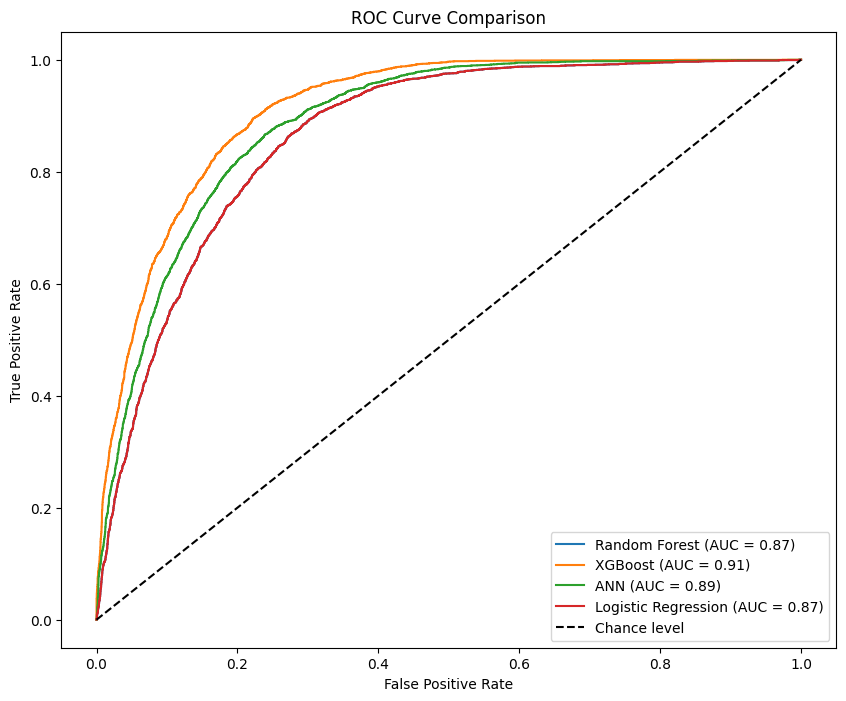

In [16]:
from sklearn.metrics import roc_curve, auc
#  We can carry on ROC and other metrics plots here
# Use scaled test set for ANN only
# y_prob_ann = ann_model.predict(X_test_scaled).ravel()

# # Other models
# y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
# y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
# y_prob_lr = logreg.predict_proba(X_test)[:, 1]

# Compute ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_gb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc_ann:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

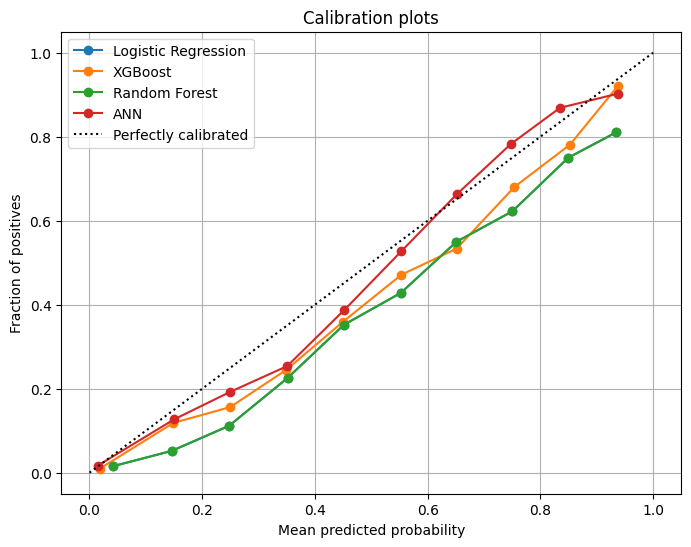

In [17]:

# Calibration plot
plt.figure(figsize=(8, 6))

for model_name, y_prob in [
    ('Logistic Regression', y_prob),
    ('XGBoost', y_prob_gb),
    ('Random Forest', y_prob_rf),
    ('ANN', y_prob_ann)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
threshold = 0.5

# Apply threshold to get predicted classes
y_pred_logreg = (y_prob > threshold).astype(int)
y_pred_xgb    = (y_prob_gb > threshold).astype(int)
y_pred_rf     = (y_prob_rf > threshold).astype(int)
y_pred_ann    = (y_prob_ann > threshold).astype(int)

# Calculate Matthews Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

mcc_logreg = matthews_corrcoef(y_test, y_pred_logreg)
mcc_xgb    = matthews_corrcoef(y_test, y_pred_xgb)
mcc_rf     = matthews_corrcoef(y_test, y_pred_rf)
mcc_ann    = matthews_corrcoef(y_test, y_pred_ann)

print(f"MCC - Logistic Regression: {mcc_logreg:.4f}")
print(f"MCC - XGBoost: {mcc_xgb:.4f}")
print(f"MCC - Random Forest: {mcc_rf:.4f}")
print(f"MCC - ANN: {mcc_ann:.4f}")

MCC - Logistic Regression: 0.5918
MCC - XGBoost: 0.6393
MCC - Random Forest: 0.5534
MCC - ANN: 0.5918


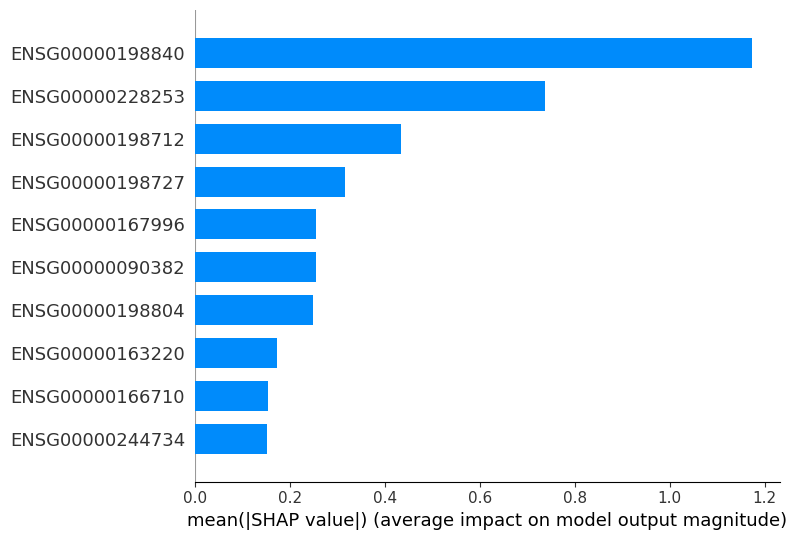

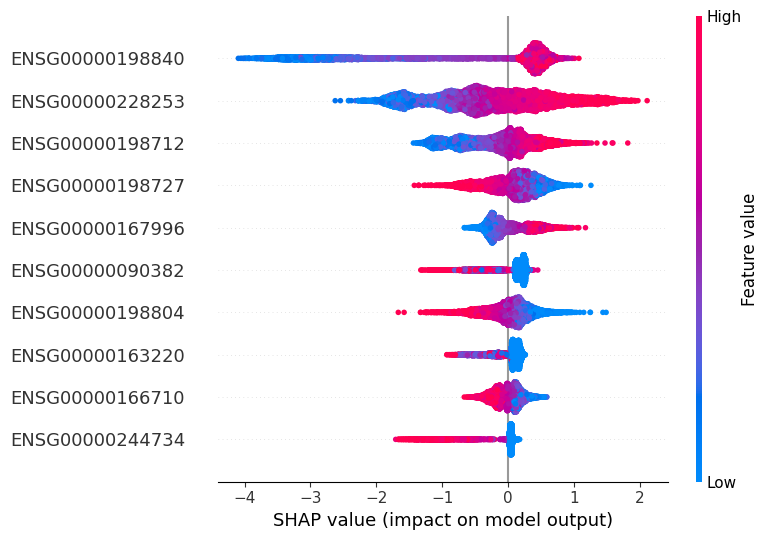

In [19]:
# Step 4 interpret the results

# Compute SHAP values
explainer = shap.TreeExplainer(model_gb)
shap_values = explainer.shap_values(X_test)

# Top 10 features by mean absolute SHAP
top_idx = np.argsort(np.abs(shap_values).mean(axis=0))[-10:]
X_top = X_test[:, top_idx]
shap_top = shap_values[:, top_idx]
feature_names = X.columns[top_idx]

# SHAP summary plots
shap.summary_plot(shap_top, X_top, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_top, X_top, feature_names=feature_names)